In [1]:
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import models

from scripts.data_processing import CustomDataset, create_datasets, get_image_transforms, get_mask_transforms
from scripts.image_processing import show_image_and_mask, visualize_predictions
from scripts.model_processing import train_torch, evaluate_torch, calculate_iou_torch

## Создаем датасеты

Использовался датасет [Brain MRI segmentation](https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation)

In [2]:
# распределяем фалы по датасетам
train_df, test_df, val_df = create_datasets(path = 'data/Brain_MRI_segmentation/', test_size = 0.2, val_size = 0.1)

Всего записей: 3929
Тренировочных: 2750
Тестовых: 786
Валидационных: 393


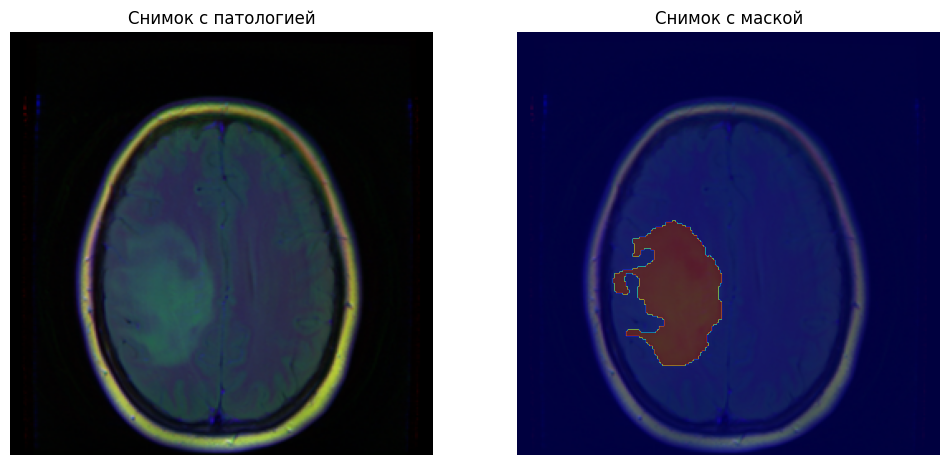

In [7]:
# выводим изображение и маску для случайного изображения
path = train_df[train_df['PATHOLOGY_LABEL'] == 1]
show_image_and_mask(path.iloc[random.randint(0, len(path))])

## Преобразовываем данные для PyTorch

In [4]:
# устанавливаем устройтсво CUDA и проверяем, что все работает
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'device: {device}')

device: cuda


In [5]:
# Создание преобразований
train_transform = get_image_transforms()
mask_transform = get_mask_transforms()

# Создание датасетов
train_dataset = CustomDataset(train_df, image_transform=train_transform, mask_transform=mask_transform)
test_dataset = CustomDataset(test_df, image_transform=train_transform, mask_transform=mask_transform)
val_dataset = CustomDataset(val_df, image_transform=train_transform, mask_transform=mask_transform)

# Использование DataLoader для пакетной загрузки данных
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## DeepLabV3 с ResNet50

In [6]:
# Создаем модель DeepLabV3 с ResNet50 и добавляем полносвязный слой для бинарной классификации
model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)
model = model.to(device)

# Оптимизатор и функция потерь
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

d:\MLE\Luna16\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\MLE\Luna16\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Основной цикл обучения с сохранением лучшей модели
num_epochs = 25
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    train_loss = train_torch(model, train_loader, optimizer, criterion, device)
    test_loss = evaluate_torch(model, test_loader, criterion, device)
    val_loss = evaluate_torch(model, val_loader, criterion, device)
    val_accuracy = calculate_iou_torch(model, val_loader, device)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val IoU: {val_accuracy:.4f}")

    # Сохранение модели, если текущая точность лучше
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'models/best_model.pth')
        print(f"Сохранена новая лучшая модель с IoU: {best_val_accuracy:.4f}")

Epoch 1/25, Train Loss: 0.4104, Test Loss: 0.2771, Val Loss: 0.2822, Val IoU: 0.5537
Сохранена новая лучшая модель с IoU: 0.5537
Epoch 2/25, Train Loss: 0.2126, Test Loss: 0.1713, Val Loss: 0.1715, Val IoU: 0.6478
Сохранена новая лучшая модель с IoU: 0.6478
Epoch 3/25, Train Loss: 0.1434, Test Loss: 0.1203, Val Loss: 0.1200, Val IoU: 0.6942
Сохранена новая лучшая модель с IoU: 0.6942
Epoch 4/25, Train Loss: 0.1051, Test Loss: 0.0898, Val Loss: 0.0901, Val IoU: 0.7115
Сохранена новая лучшая модель с IoU: 0.7115
Epoch 5/25, Train Loss: 0.0801, Test Loss: 0.0695, Val Loss: 0.0698, Val IoU: 0.7082
Epoch 6/25, Train Loss: 0.0625, Test Loss: 0.0548, Val Loss: 0.0547, Val IoU: 0.7243
Сохранена новая лучшая модель с IoU: 0.7243
Epoch 7/25, Train Loss: 0.0498, Test Loss: 0.0445, Val Loss: 0.0446, Val IoU: 0.7399
Сохранена новая лучшая модель с IoU: 0.7399
Epoch 8/25, Train Loss: 0.0404, Test Loss: 0.0381, Val Loss: 0.0383, Val IoU: 0.7437
Сохранена новая лучшая модель с IoU: 0.7437
Epoch 9/25, 

## Выводим прогноз

d:\MLE\Brain_MRI\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\MLE\Brain_MRI\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Temp\ipykernel_11728\893561385.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the func

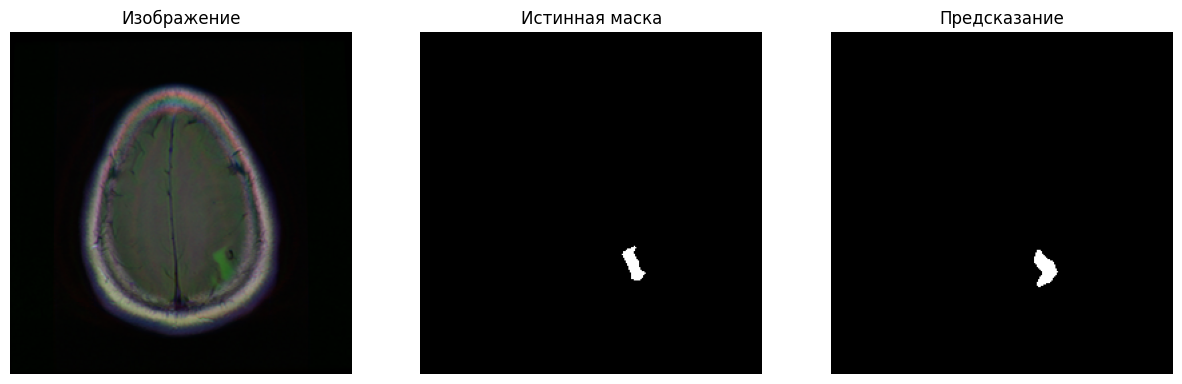

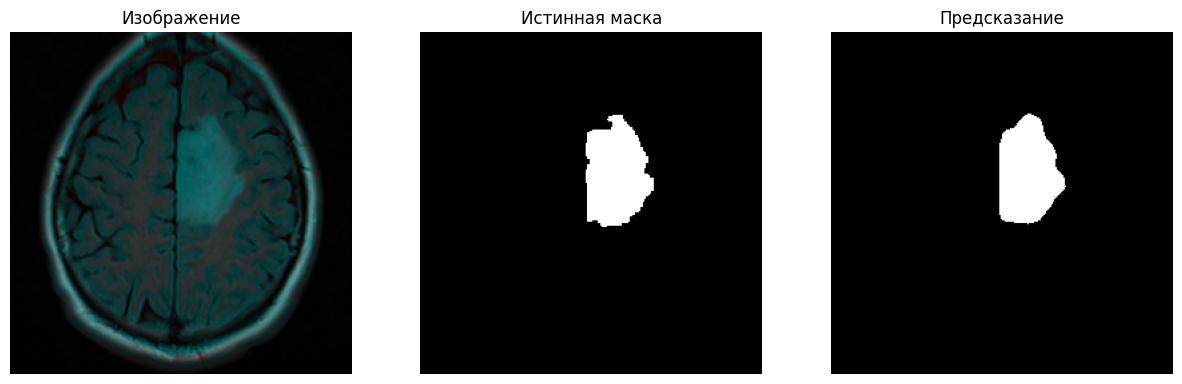

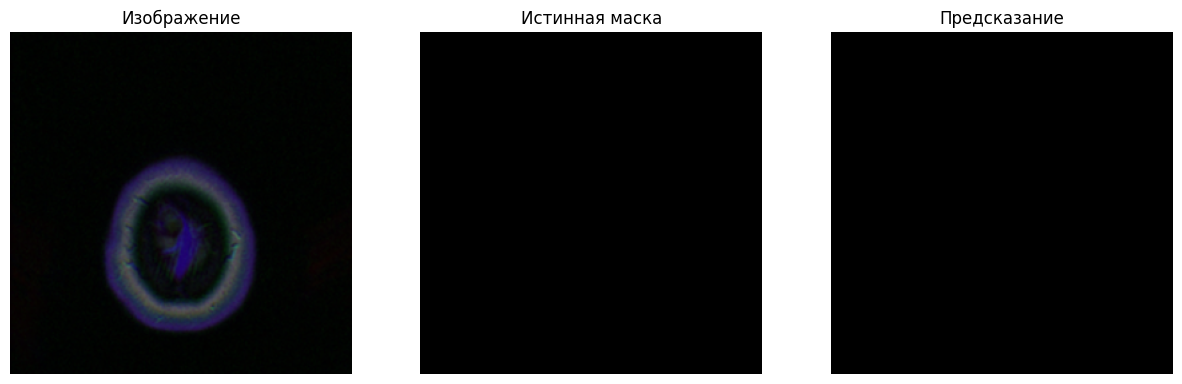

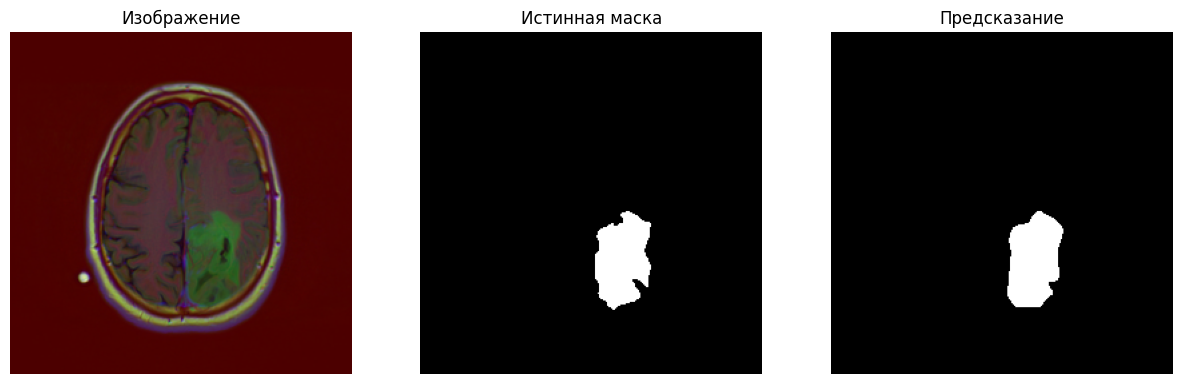

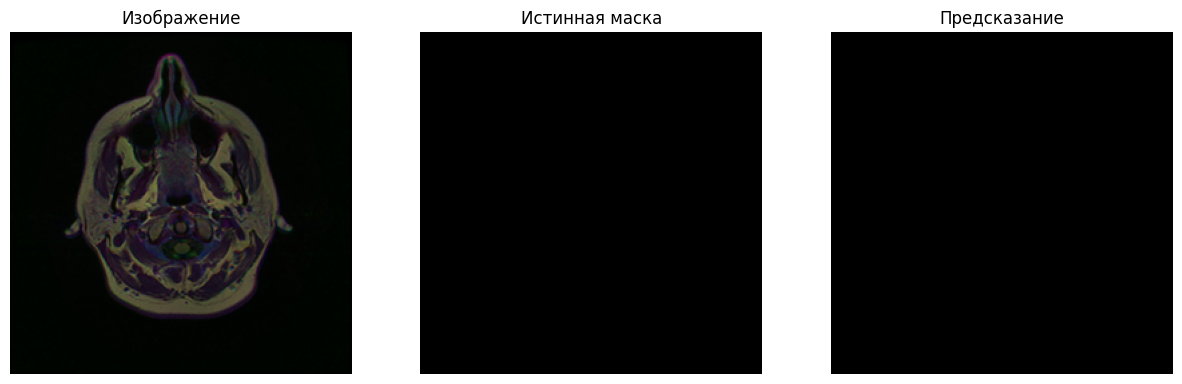

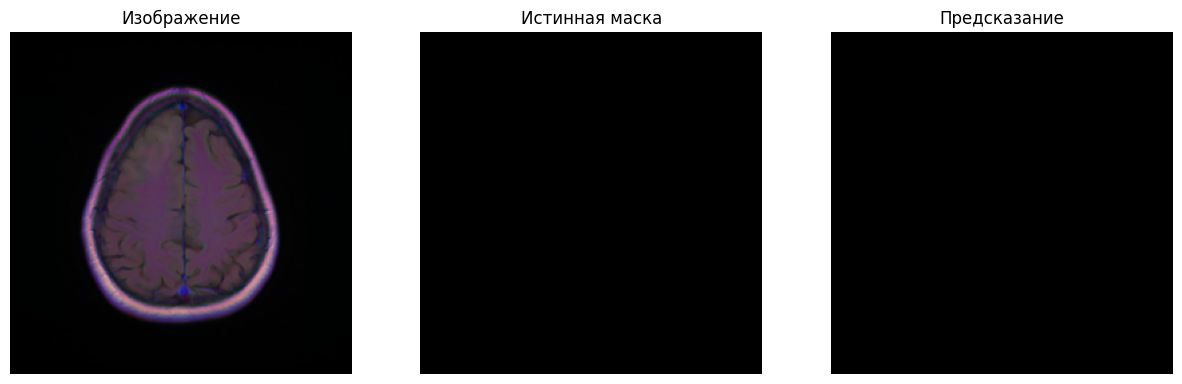

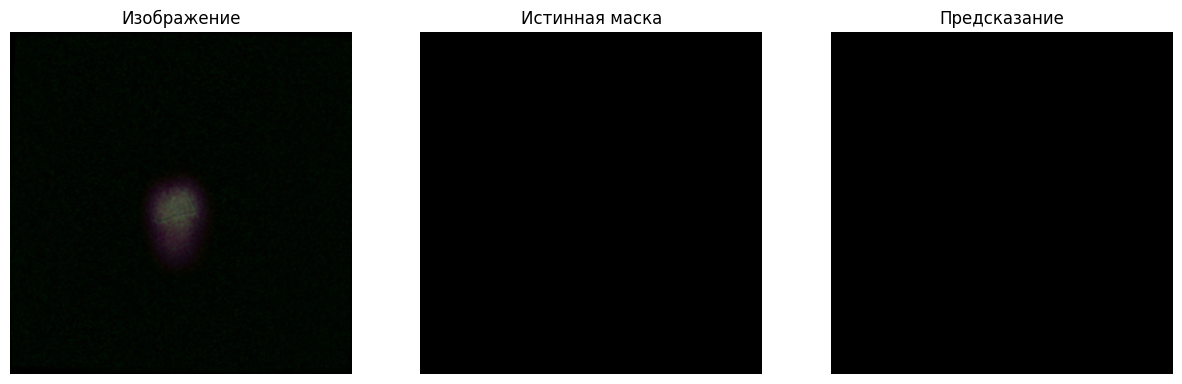

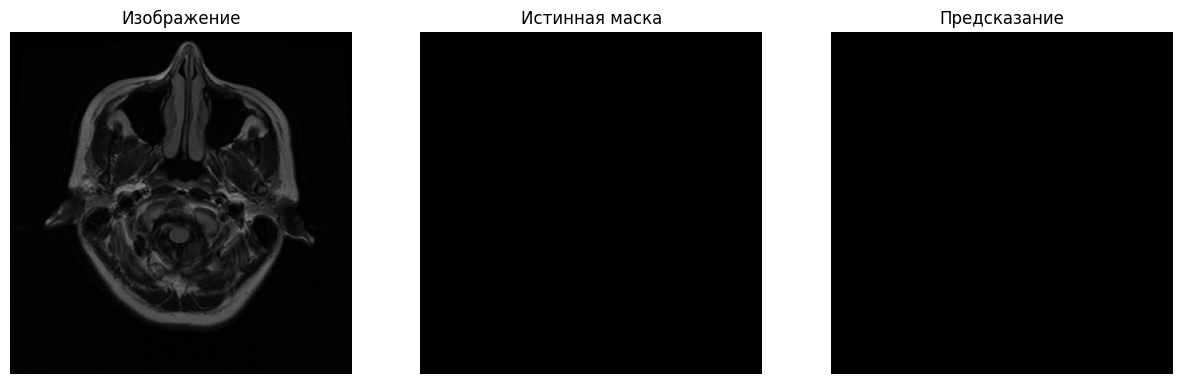

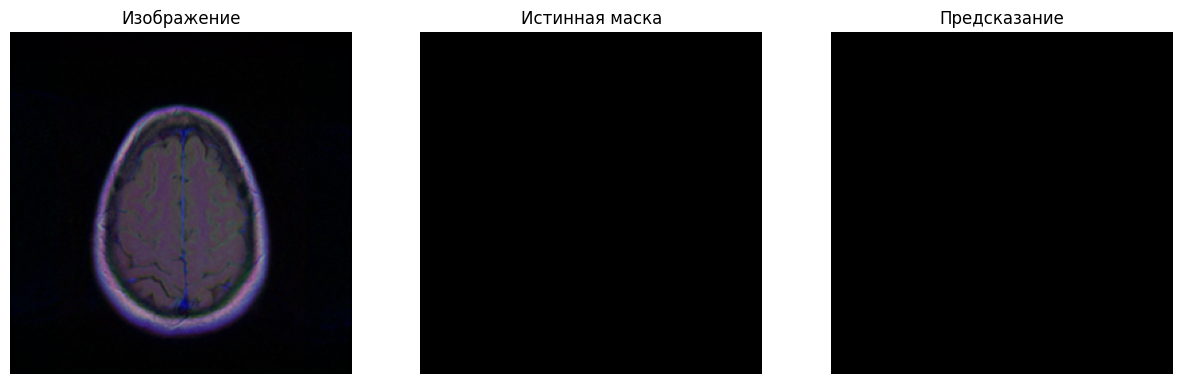

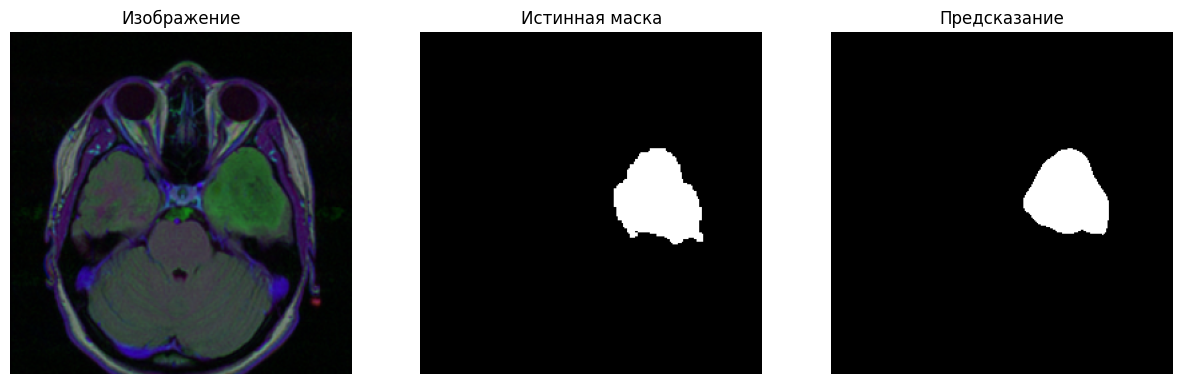

In [6]:
# Инициализация модели DeepLabV3 с ResNet50
load_model = models.segmentation.deeplabv3_resnet50(pretrained=False)
load_model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)

# Перевод модели на устройство
load_model = load_model.to(device)

# Загрузка сохраненных весов с отключением строгой проверки ключей
checkpoint = torch.load('models/best_model.pth', map_location=device)
load_model.load_state_dict(checkpoint, strict=False)

# Перевод модели в режим оценки
load_model.eval()

# Визуализация предсказаний
visualize_predictions(load_model, val_loader, device=device, num_images=10)